In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.models.segmentation import DeepLabV3_ResNet50_Weights
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

c:\Users\skoka3\.conda\envs\ooga\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Mount the drive

## Visualizing Coarse damage

In [2]:
#replace with your directory
im1 = Image.open('/content/drive/MyDrive/Semantic_Segmentation_Cracks/Damage_dataset/imageDamage/01_RCB0017_F01_DSC_0076000.jpg')
im2 = Image.open('/content/drive/MyDrive/Semantic_Segmentation_Cracks/Damage_dataset/CoarseDamagePNG/01_RCB0017_F01_DSC_0076000.png')
image1 = np.array(im1)
image2 = np.array(im2)

# # # Create a 1x2 grid of subplots
plt.figure(figsize=(12, 6))  # Set the figure size
plt.subplot(1, 2, 1)  # Subplot 1
plt.imshow(image1)  # Display the first image
plt.axis('off')  # Hide the axis

plt.subplot(1, 2, 2)  # Subplot 2
plt.imshow(image2)  # Display the second image
plt.axis('off')  # Hide the axis

plt.show()  # Show the plot


## Loading the Coarse damage dataset

In [3]:
class CustomSemanticSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, target_transform=None, target_size=(512, 512)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.target_transform = target_transform  # Separate transform for masks
        self.target_size = target_size
        self.num_classes = 8

        # Include only image files
        self.image_filenames = [f for f in sorted(os.listdir(image_dir))
                                if f.lower().endswith(('.png', '.jpg', '.jpeg'))]


    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.image_filenames[idx].replace('.jpg', '.png'))

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path)

        # Resize the image and mask
        image = image.resize(self.target_size, Image.BILINEAR)
        mask = mask.resize(self.target_size, Image.NEAREST)

        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            mask = self.target_transform(mask)

        # Convert mask to numpy array for processing
        mask = np.array(mask)

        # Create one-hot encoding for mask
        mask_one_hot = torch.zeros((self.num_classes, *self.target_size), dtype=torch.float32)
        for class_idx in range(self.num_classes):
            mask_one_hot[class_idx] = torch.from_numpy(mask == class_idx).float()

        return image, mask_one_hot


## load train and test data got from data_split.py - coarse

In [6]:
#replace with your directory
train_image_dir = r"/Users/sujitharavichandran/Documents/GitHub/Semantic_Segmentation_Cracks/Damage dataset/imageDamage/CoarseDamage_traintestval_split/train/images"
test_image_dir = r"/Users/sujitharavichandran/Documents/GitHub/Semantic_Segmentation_Cracks/Damage dataset/imageDamage/CoarseDamage_traintestval_split/test/images"
train_mask_dir = r"/Users/sujitharavichandran/Documents/GitHub/Semantic_Segmentation_Cracks/Damage dataset/imageDamage/CoarseDamage_traintestval_split/train/masks"
test_mask_dir = r"/Users/sujitharavichandran/Documents/GitHub/Semantic_Segmentation_Cracks/Damage dataset/imageDamage/CoarseDamage_traintestval_split/test/masks"

## Train the model

In [7]:
# Define hyperparameters
batch_size = 4
learning_rate = 0.001
num_epochs = 100
num_classes = 8

# Define your custom dataset and data loaders

train_dataset = CustomSemanticSegmentationDataset(train_image_dir, train_mask_dir, transform=transforms.Compose([transforms.ToTensor()]), target_size=(512,512))
test_dataset = CustomSemanticSegmentationDataset(test_image_dir, test_mask_dir, transform=transforms.Compose([transforms.ToTensor()]), target_size=(512,512))

# Create data loaders for each set
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Load a pre-trained DeepLabV3 model
weights = DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
model = models.segmentation.deeplabv3_resnet50(weights=weights)

# Modify the classifier for 8 classes
model.classifier[4] = nn.Conv2d(model.classifier[4].in_channels, num_classes, kernel_size=1)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

for epoch in range(num_epochs):
    total_loss = 0.0
    num_batches = 0

    for inputs, masks in train_loader:
        inputs, masks = inputs.to(device), masks.to(device)
        masks = masks.squeeze(1)  # Remove channel dimension if present
        optimizer.zero_grad()
        outputs = model(inputs)['out']
        loss = criterion(outputs, masks)  # Ensure masks are long type
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    average_loss = total_loss / num_batches
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.4f}")

# Save the fine-tuned model
torch.save(model.state_dict(), 'fine_tuned_segmentation_model_trainimages_100epochs.pth')


Epoch 1/100, Loss: 0.4473
Epoch 2/100, Loss: 0.3095
Epoch 3/100, Loss: 0.2872
Epoch 4/100, Loss: 0.2581
Epoch 5/100, Loss: 0.2534
Epoch 6/100, Loss: 0.2453
Epoch 7/100, Loss: 0.2287
Epoch 8/100, Loss: 0.2250
Epoch 9/100, Loss: 0.2201
Epoch 10/100, Loss: 0.2210
Epoch 11/100, Loss: 0.2143
Epoch 12/100, Loss: 0.2116
Epoch 13/100, Loss: 0.2023
Epoch 14/100, Loss: 0.1995
Epoch 15/100, Loss: 0.1912
Epoch 16/100, Loss: 0.2028
Epoch 17/100, Loss: 0.1910
Epoch 18/100, Loss: 0.1869
Epoch 19/100, Loss: 0.1758
Epoch 20/100, Loss: 0.1867
Epoch 21/100, Loss: 0.1825
Epoch 22/100, Loss: 0.1827
Epoch 23/100, Loss: 0.1781
Epoch 24/100, Loss: 0.1678
Epoch 25/100, Loss: 0.1643
Epoch 26/100, Loss: 0.1668
Epoch 27/100, Loss: 0.1605
Epoch 28/100, Loss: 0.1596
Epoch 29/100, Loss: 0.1557
Epoch 30/100, Loss: 0.1528
Epoch 31/100, Loss: 0.1424
Epoch 32/100, Loss: 0.1439
Epoch 33/100, Loss: 0.1389
Epoch 34/100, Loss: 0.1492
Epoch 35/100, Loss: 0.1357
Epoch 36/100, Loss: 0.1317
Epoch 37/100, Loss: 0.1288
Epoch 38/1

In [12]:
# Define the IoU calculation function
def calculate_iou(predicted_mask, ground_truth_mask, num_classes):
    iou_list = []
    for cls in range(num_classes):
        pred_inds = predicted_mask == cls
        target_inds = ground_truth_mask == cls
        intersection = pred_inds[target_inds].sum()
        union = pred_inds.sum() + target_inds.sum() - intersection
        if union == 0:
            iou = float('nan')  # Exclude from evaluation if no ground truth
        else:
            iou = float(intersection) / float(max(union, 1))
        iou_list.append(iou)
    return np.nanmean(iou_list)  # Return the mean IoU value for this image


model = models.segmentation.deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1)
num_classes = 8
model.classifier[4] = nn.Conv2d(model.classifier[4].in_channels, num_classes, kernel_size=1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Load the saved state_dict
model.load_state_dict(torch.load('fine_tuned_segmentation_model_trainimages_100epochs.pth'))
model.eval()

iou_values = []

# Assuming you have a test loader named 'test_loader'
# and it returns batches of images and masks
for i, (input_images, ground_truth_masks) in enumerate(test_loader):
    input_images = input_images.to(device)
    ground_truth_masks = ground_truth_masks.to(device)

    # Perform inference
    with torch.no_grad():
        output = model(input_images)

    # Extract the predicted segmentation masks
    predicted_masks = output['out'].argmax(1).cpu().numpy()  # Move to CPU and convert to numpy

    # Convert ground truth masks from one-hot encoded to 2D format
    ground_truth_masks_2d = ground_truth_masks.max(1)[1].cpu().numpy()  # (batch_size, height, width)

    for j in range(predicted_masks.shape[0]):  # Loop over each image in the batch
        # Compute IoU for each image
        iou = calculate_iou(predicted_masks[j], ground_truth_masks_2d[j], num_classes)
        iou_values.append(iou)

# Calculate mean IoU
mean_iou = np.nanmean(iou_values)
print(f"Mean IoU: {mean_iou}")






Mean IoU: 0.4325088097371532


## Color map function

In [8]:
# Define your color map
color_map = {
    0: [0, 0, 0],          # No - black
    1: [128, 128, 128],    # Shadows - grey
    2: [218, 165, 32],     # Dirt - goldenrod
    3: [0, 255, 127],      # Vegetative Growth - springgreen
    4: [255, 0, 255],      # Debris - fuchsia
    5: [128, 0, 128],      # Marks - purple
    6: [255, 99, 71],      # Spalling - tomato
    7: [255, 255, 0]       # Voids - yellow
}

# Function to apply color mapping to an image
def apply_color_map(image, color_map):
    height, width = image.shape
    color_mask = np.zeros((height, width, 3), dtype=np.uint8)
    for key, color in color_map.items():
        indices = image == key
        color_mask[indices] = color
    return color_mask

## Inference - model trained on all images and 10 epoch

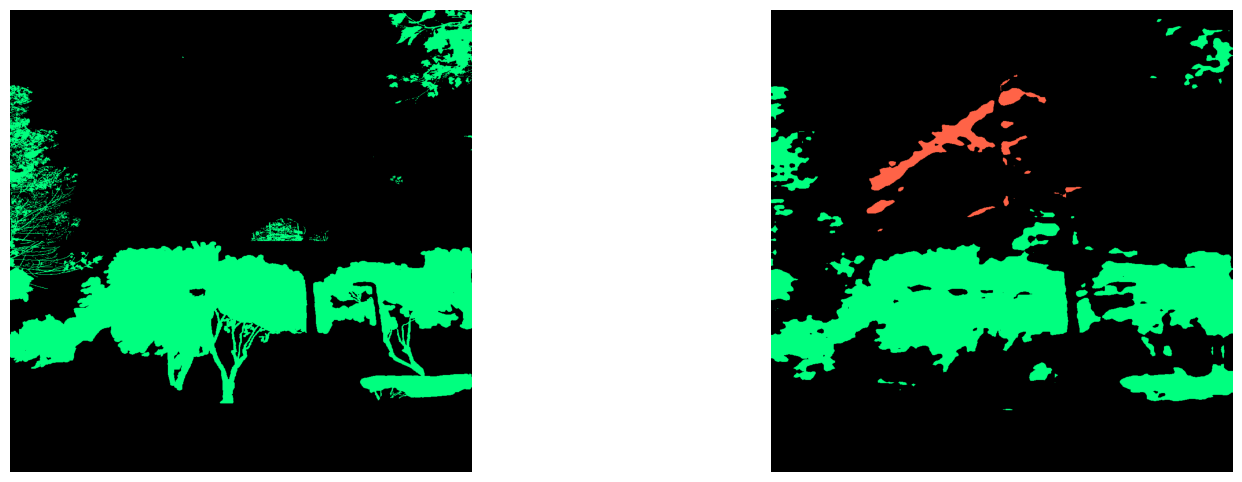

In [ ]:


# Load the fine-tuned model

model = models.segmentation.deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1)
num_classes = 8
model.classifier[4] = nn.Conv2d(model.classifier[4].in_channels, num_classes, kernel_size=1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Load the saved state_dict
model.load_state_dict(torch.load('/content/drive/MyDrive/Semantic_Segmentation_Cracks/fine_tuned_segmentation_model_allimages_10epochs.pth'))
model.eval()

# Load and preprocess the image for inference
image_path = '/content/drive/MyDrive/Semantic_Segmentation_Cracks/Damage_dataset/imageDamage/01_RCB0017_F01_DSC_0076000.jpg'
image = Image.open(image_path)
transform = transforms.Compose([
    transforms.ToTensor(),
  # Normalize with ImageNet statistics
])
input_image = transform(image).unsqueeze(0)  # Add a batch dimension
input_image = input_image.to(device)


# Perform inference
with torch.no_grad():
    output = model(input_image)

# Extract the predicted segmentation mask
predicted_mask = output['out'].argmax(1).squeeze().cpu().numpy()
predicted_mask_image = Image.fromarray(predicted_mask.astype(np.uint8))
resized_predicted_mask = predicted_mask_image.resize((1024, 1024), resample=Image.NEAREST)
predicted_mask = np.array(resized_predicted_mask)
predicted_mask = apply_color_map(predicted_mask, color_map)

ground_truth_mask = Image.open('/content/drive/MyDrive/Semantic_Segmentation_Cracks/Damage_dataset/CoarseDamagePNG/01_RCB0017_F01_DSC_0076000.png')
ground_truth_mask = ground_truth_mask.resize((1024, 1024), resample=Image.NEAREST)
ground_truth_mask = np.array(ground_truth_mask)
ground_truth_color_mask = apply_color_map(ground_truth_mask, color_map)


# Create a 1x3 grid of subplots
plt.figure(figsize=(18, 6))  # Adjust the figure size as needed
plt.subplot(1, 2, 1)  # Subplot 1
plt.imshow(ground_truth_color_mask)  # Display the original image
plt.axis('off')  # Hide the axis

plt.subplot(1, 2, 2)  # Subplot 2
plt.imshow(predicted_mask)  # Display the color-coded predicted mask
plt.axis('off')  #

plt.show()



## Inference - model trained on all images and 100 epochs

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 170MB/s]


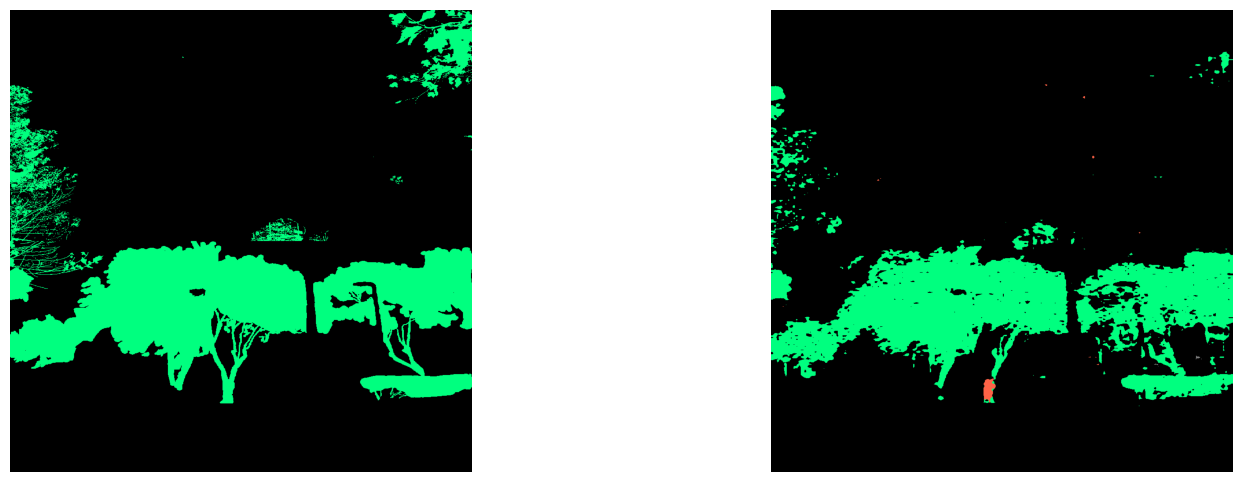

In [ ]:

# Load the fine-tuned model

model = models.segmentation.deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1)
num_classes = 8
model.classifier[4] = nn.Conv2d(model.classifier[4].in_channels, num_classes, kernel_size=1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Load the saved state_dict
model.load_state_dict(torch.load('/content/drive/MyDrive/Semantic_Segmentation_Cracks/deeplab_100E_16BS_512.pth'))
model.eval()

# Load and preprocess the image for inference
image_path = '/content/drive/MyDrive/Semantic_Segmentation_Cracks/Damage_dataset/imageDamage/01_RCB0017_F01_DSC_0076000.jpg'
image = Image.open(image_path)
transform = transforms.Compose([
    transforms.ToTensor(),
  # Normalize with ImageNet statistics
])
input_image = transform(image).unsqueeze(0)  # Add a batch dimension
input_image = input_image.to(device)


# Perform inference
with torch.no_grad():
    output = model(input_image)

# Extract the predicted segmentation mask
predicted_mask = output['out'].argmax(1).squeeze().cpu().numpy()
predicted_mask_image = Image.fromarray(predicted_mask.astype(np.uint8))
resized_predicted_mask = predicted_mask_image.resize((1024, 1024), resample=Image.NEAREST)
predicted_mask = np.array(resized_predicted_mask)
predicted_mask = apply_color_map(predicted_mask, color_map)

ground_truth_mask = Image.open('/content/drive/MyDrive/Semantic_Segmentation_Cracks/Damage_dataset/CoarseDamagePNG/01_RCB0017_F01_DSC_0076000.png')
ground_truth_mask = ground_truth_mask.resize((1024, 1024), resample=Image.NEAREST)
ground_truth_mask = np.array(ground_truth_mask)
ground_truth_color_mask = apply_color_map(ground_truth_mask, color_map)


# Create a 1x3 grid of subplots
plt.figure(figsize=(18, 6))  # Adjust the figure size as needed
plt.subplot(1, 2, 1)  # Subplot 1
plt.imshow(ground_truth_color_mask)  # Display the original image
plt.axis('off')  # Hide the axis

plt.subplot(1, 2, 2)  # Subplot 2
plt.imshow(predicted_mask)  # Display the color-coded predicted mask
plt.axis('off')  #

plt.show()



## Inference model trained on all images - 100 epochs 

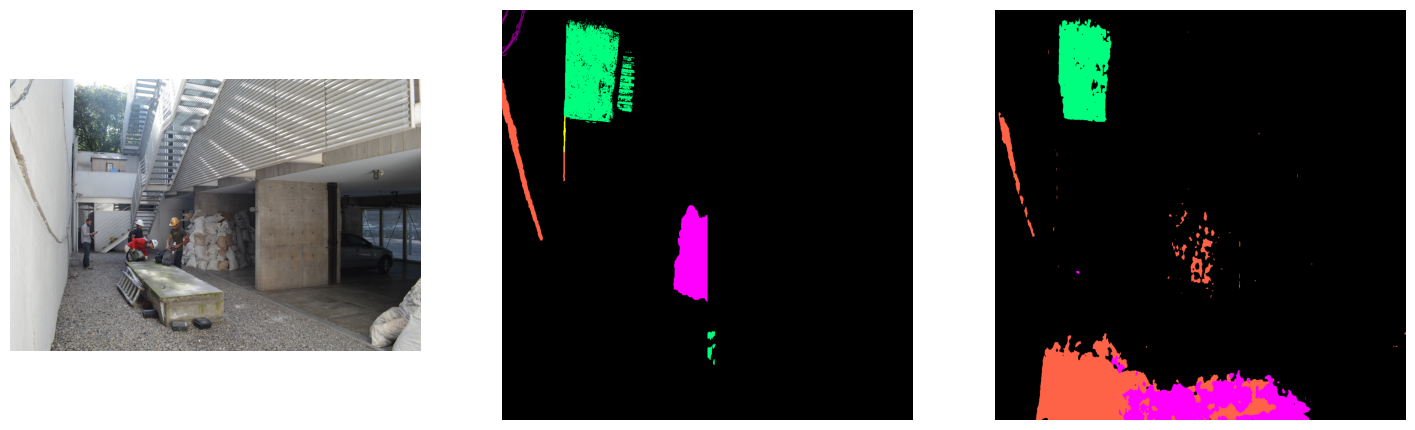

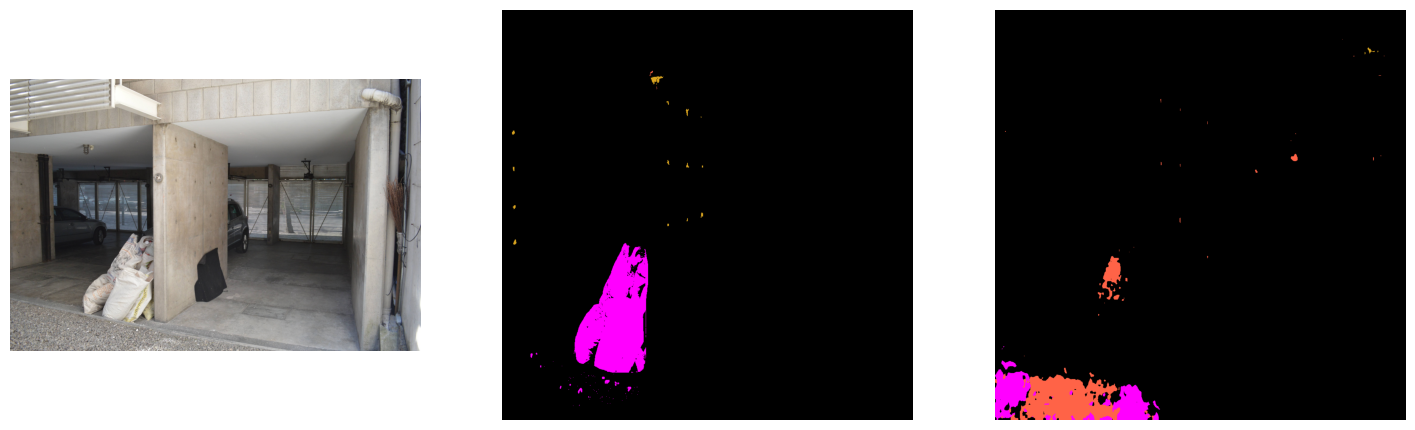

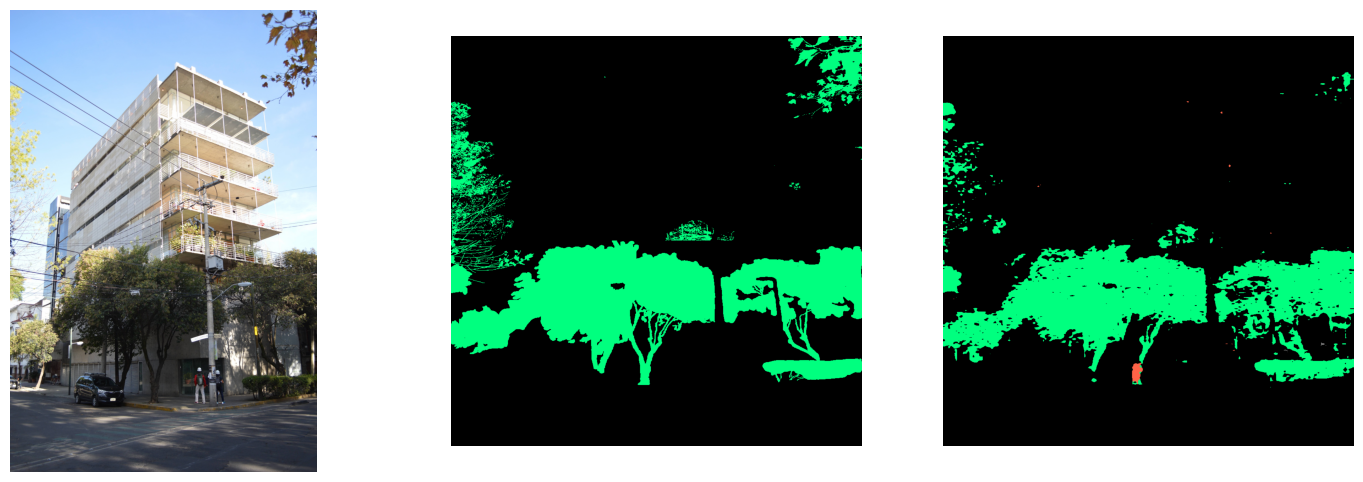

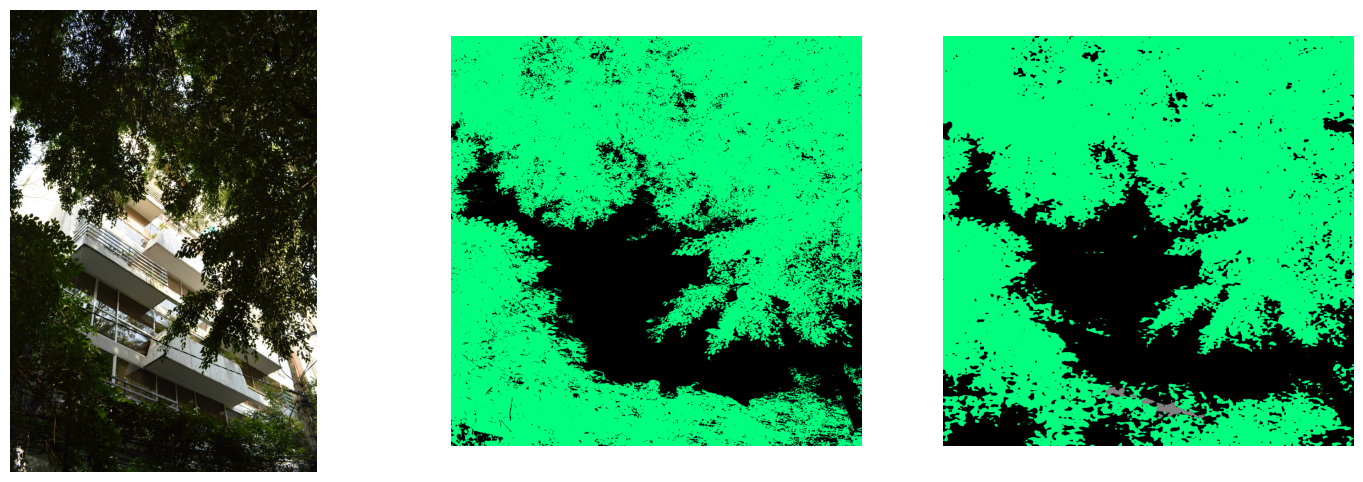

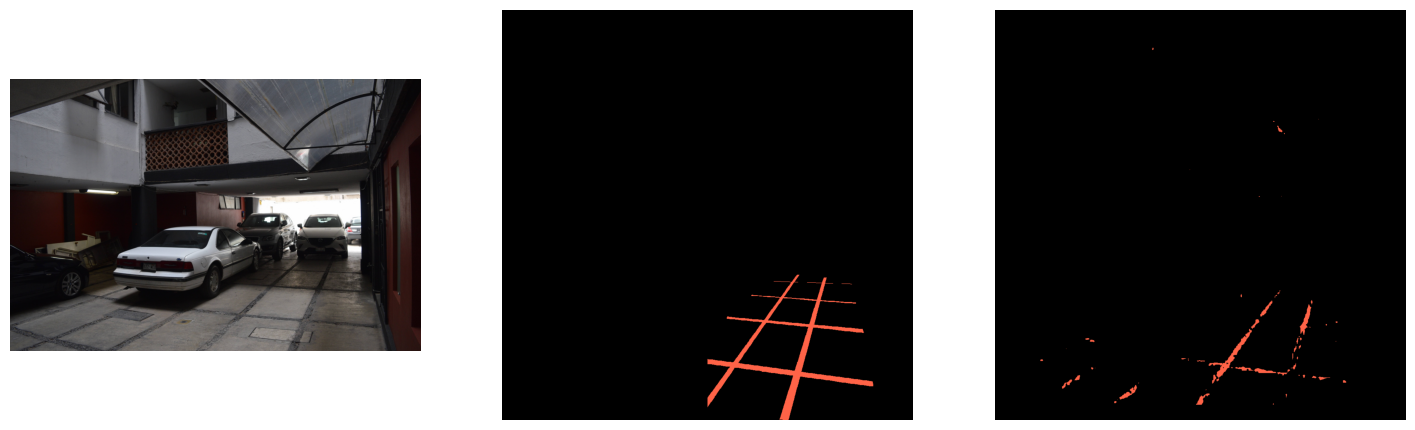

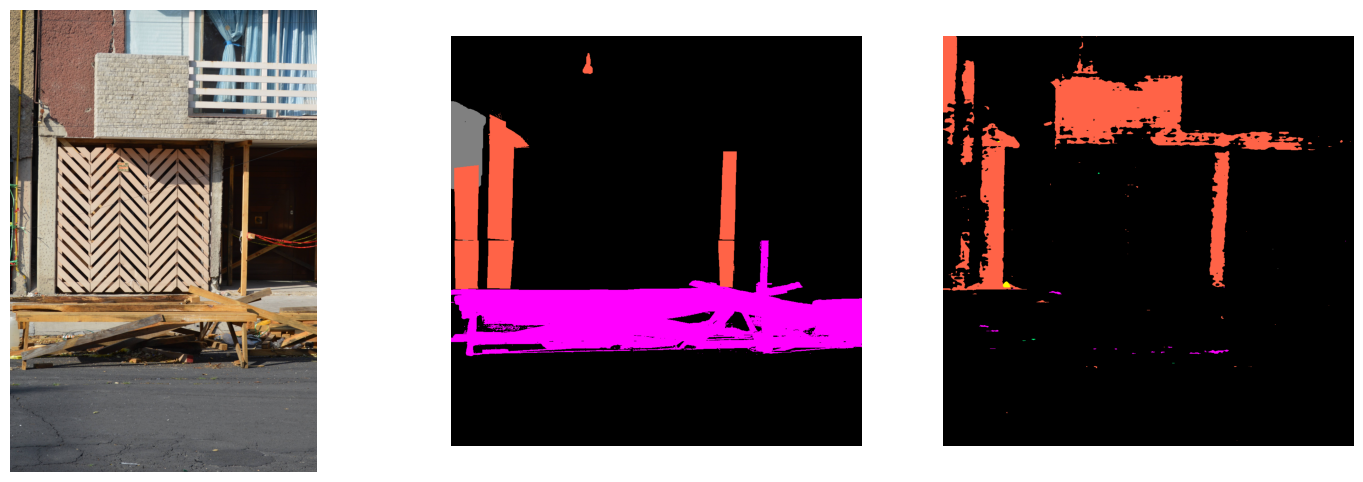

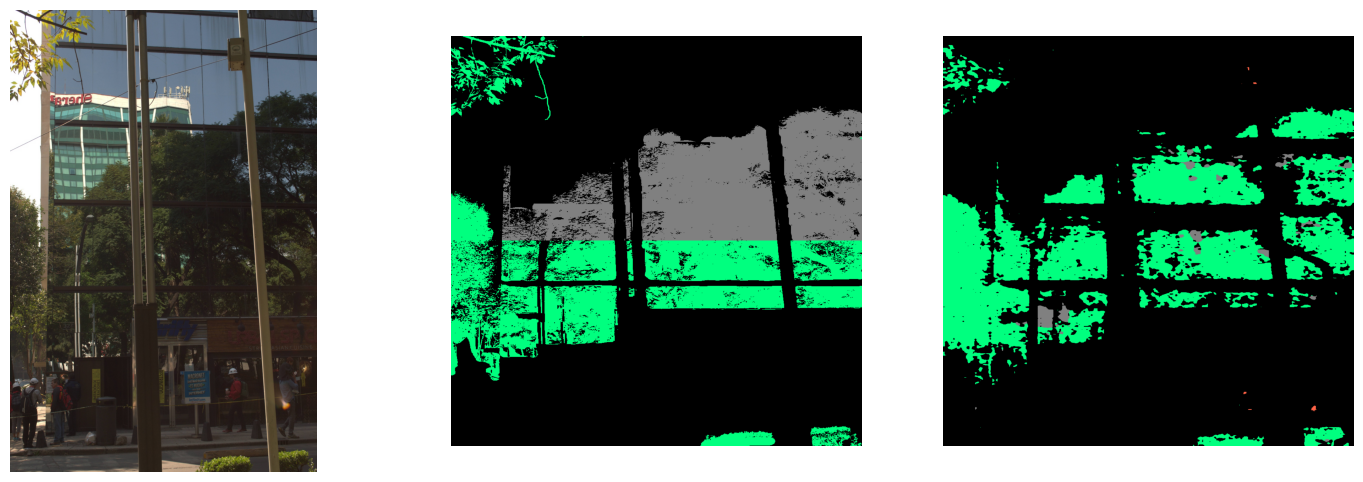

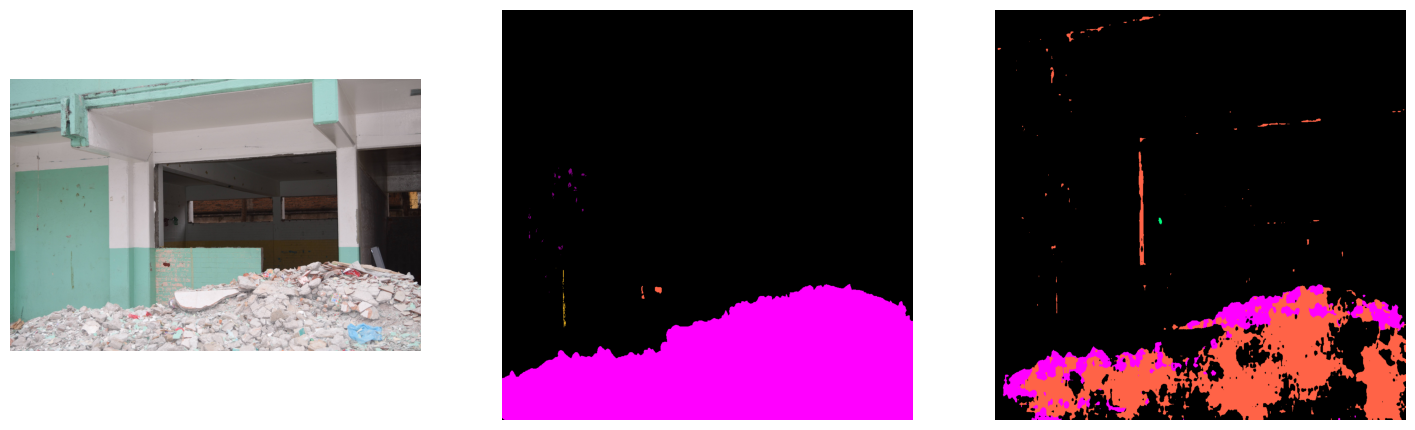

In [ ]:

# Load the fine-tuned model
model = models.segmentation.deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1)
num_classes = 8
model.classifier[4] = nn.Conv2d(model.classifier[4].in_channels, num_classes, kernel_size=1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Load the saved state_dict
model.load_state_dict(torch.load('/content/drive/MyDrive/Semantic_Segmentation_Cracks/deeplab_100E_16BS_512.pth'))
model.eval()

# List of image and ground truth mask paths
image_and_mask_paths = [
    ('/content/drive/MyDrive/Semantic_Segmentation_Cracks/Damage_dataset/imageDamage/01_RCB0017_F03_DSC_0082006.jpg', '/content/drive/MyDrive/Semantic_Segmentation_Cracks/Damage_dataset/CoarseDamagePNG/01_RCB0017_F03_DSC_0082006.png'),
    ('/content/drive/MyDrive/Semantic_Segmentation_Cracks/Damage_dataset/imageDamage/01_RCB0017_F03_DSC_0080004.jpg', '/content/drive/MyDrive/Semantic_Segmentation_Cracks/Damage_dataset/CoarseDamagePNG/01_RCB0017_F03_DSC_0080004.png'),
    ('/content/drive/MyDrive/Semantic_Segmentation_Cracks/Damage_dataset/imageDamage/01_RCB0017_F01_DSC_0076000.jpg', '/content/drive/MyDrive/Semantic_Segmentation_Cracks/Damage_dataset/CoarseDamagePNG/01_RCB0017_F01_DSC_0076000.png'),
    ('/content/drive/MyDrive/Semantic_Segmentation_Cracks/Damage_dataset/imageDamage/01_RCB0018_F06_DSC_0114000.jpg','/content/drive/MyDrive/Semantic_Segmentation_Cracks/Damage_dataset/CoarseDamagePNG/01_RCB0018_F06_DSC_0114000.png'),
    ('/content/drive/MyDrive/Semantic_Segmentation_Cracks/Damage_dataset/imageDamage/01_RCB0020_F05_DSC_0464006.jpg','/content/drive/MyDrive/Semantic_Segmentation_Cracks/Damage_dataset/CoarseDamagePNG/01_RCB0020_F05_DSC_0464006.png'),
    ('/content/drive/MyDrive/Semantic_Segmentation_Cracks/Damage_dataset/imageDamage/02_RCB0025_F02_DSC_0101010.jpg','/content/drive/MyDrive/Semantic_Segmentation_Cracks/Damage_dataset/CoarseDamagePNG/02_RCB0025_F02_DSC_0101010.png'),
    ('/content/drive/MyDrive/Semantic_Segmentation_Cracks/Damage_dataset/imageDamage/02_RCB0033_F02_DSC_0350000.jpg','/content/drive/MyDrive/Semantic_Segmentation_Cracks/Damage_dataset/CoarseDamagePNG/02_RCB0033_F02_DSC_0350000.png'),
    ('/content/drive/MyDrive/Semantic_Segmentation_Cracks/Damage_dataset/imageDamage/04_RCB0003_F01_DSC_0037004.jpg','/content/drive/MyDrive/Semantic_Segmentation_Cracks/Damage_dataset/CoarseDamagePNG/04_RCB0003_F01_DSC_0037004.png'),

    # ... add more pairs as needed
]

for i, (image_path, mask_path) in enumerate(image_and_mask_paths):
    # Load and preprocess the image
    image = Image.open(image_path)
    image1 = np.array(image)
    transform = transforms.Compose([transforms.ToTensor()])
    input_image = transform(image).unsqueeze(0)  # Add a batch dimension
    input_image = input_image.to(device)


    # Perform inference
    with torch.no_grad():
        output = model(input_image)

    # Extract the predicted segmentation mask
    predicted_mask = output['out'].argmax(1).squeeze().cpu().numpy()
    predicted_mask_image = Image.fromarray(predicted_mask.astype(np.uint8))
    resized_predicted_mask = predicted_mask_image.resize((1024, 1024), resample=Image.NEAREST)
    predicted_mask = np.array(resized_predicted_mask)
    predicted_mask = apply_color_map(predicted_mask, color_map)

    # Load and process the ground truth mask
    ground_truth_mask = Image.open(mask_path)
    ground_truth_mask = ground_truth_mask.resize((1024, 1024), resample=Image.NEAREST)
    ground_truth_mask = np.array(ground_truth_mask)
    ground_truth_color_mask = apply_color_map(ground_truth_mask, color_map)

    # Plotting
    plt.figure(figsize=(18, 6))  # Adjust the figure size as needed


    plt.subplot(1, 3, 1)  # Subplot 1
    plt.imshow(image1)  # Display the ground truth mask
    plt.axis('off')

    plt.subplot(1, 3, 2)  # Subplot 1
    plt.imshow(ground_truth_color_mask)  # Display the ground truth mask
    plt.axis('off')  # Hide the axis

    plt.subplot(1, 3, 3)  # Subplot 2
    plt.imshow(predicted_mask)  # Display the predicted mask
    plt.axis('off')  # Hide the axis

    save_path = '/content/drive/MyDrive/Semantic_Segmentation_Cracks/Results/'
    os.makedirs(save_path, exist_ok=True)  # Ensure the directory exists
    save_filename = os.path.join(save_path, f"result_{i}.png")
    plt.savefig(save_filename)
    plt.show()


## Total number of parameters

In [ ]:
import torch
import torchvision
from torchvision.models.segmentation import deeplabv3_resnet50

# Initialize DeepLabV3 with a ResNet-50 backbone
model = deeplabv3_resnet50(pretrained=False)

# Calculate the total number of parameters
total_params = sum(p.numel() for p in model.parameters())

total_params

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 39.2MB/s]


39638869

## Mean IOU calculation on the test dataset

In [21]:
# Define the IoU calculation function
def calculate_iou(predicted_mask, ground_truth_mask, num_classes):
    iou_list = []
    for cls in range(num_classes):
        pred_inds = predicted_mask == cls
        target_inds = ground_truth_mask == cls
        intersection = pred_inds[target_inds].sum()
        union = pred_inds.sum() + target_inds.sum() - intersection
        if union == 0:
            iou = float('nan')  # Exclude from evaluation if no ground truth
        else:
            iou = float(intersection) / float(max(union, 1))
        iou_list.append(iou)
    return np.nanmean(iou_list)  # Return the mean IoU value for this image


model = models.segmentation.deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1)
num_classes = 8
model.classifier[4] = nn.Conv2d(model.classifier[4].in_channels, num_classes, kernel_size=1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Load the saved state_dict
model.load_state_dict(torch.load('fine_tuned_segmentation_model_trainimages_15epochs.pth'))
model.eval()

iou_values = []

# Assuming you have a test loader named 'test_loader'
# and it returns batches of images and masks
for i, (input_images, ground_truth_masks) in enumerate(test_loader):
    input_images = input_images.to(device)
    ground_truth_masks = ground_truth_masks.to(device)

    # Perform inference
    with torch.no_grad():
        output = model(input_images)

    # Extract the predicted segmentation masks
    predicted_masks = output['out'].argmax(1).cpu().numpy()  # Move to CPU and convert to numpy

    # Convert ground truth masks from one-hot encoded to 2D format
    ground_truth_masks_2d = ground_truth_masks.max(1)[1].cpu().numpy()  # (batch_size, height, width)

    for j in range(predicted_masks.shape[0]):  # Loop over each image in the batch
        # Compute IoU for each image
        iou = calculate_iou(predicted_masks[j], ground_truth_masks_2d[j], num_classes)
        iou_values.append(iou)

# Calculate mean IoU
mean_iou = np.nanmean(iou_values)
print(f"Mean IoU: {mean_iou}")






Mean IoU: 0.42011918719996727
